In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from transformers import BertModel, BertPreTrainedModel
from transformers import BertTokenizer, BertConfig
from transformers import BertForMaskedLM, BertForNextSentencePrediction

import warnings
warnings.filterwarnings("ignore")

In [2]:
MODEL_NAME = 'bert-base-cased'
MODEL_PATH = '../input/huggingface-bert/bert-base-cased/'

OUT_NUM = 4
MAX_LEN = 75
BATCH_SIZE = 16
EPOCHS = 128
BERT_LR = 1e-5
LR = 5e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
polarity = ['positive', 'negative', 'neutral', 'conflict']

In [3]:
def get_bert_input(df):
    data = []
    for category, text in zip(df['category'].values, df['text'].values):
        encode = tokenizer.encode_plus(category, text, padding='max_length', max_length=MAX_LEN, truncation=True)
        data.append([encode['input_ids'], encode['attention_mask'], encode['token_type_ids']])
    data = torch.tensor(data).to(DEVICE)
    label = torch.tensor(df['label'].values).to(DEVICE)
    return data, label

In [4]:
class ASC_BERT(nn.Module):
    def __init__(self):
        super(ASC_BERT, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_PATH, config=config)
        self.out = nn.Linear(config.hidden_size, OUT_NUM)

    def forward(self, X):
        input_ids = X[:, 0, :]
        attention_mask = X[:, 1, :]
        token_type_ids = X[:, 2, :]
#         embed_out = self.bert(input_ids, attention_mask, token_type_ids).last_hidden_state
        embed_cls = self.bert(input_ids, attention_mask, token_type_ids).pooler_output
        out = self.out(embed_cls)
        return out

In [5]:
def get_acc(model, trial_loader):
    pred, real = [], []
    
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(trial_loader):
            pred.extend(model(batch_x.to(DEVICE)).data.max(1, keepdim=True)[1].tolist())
            real.extend(batch_y.data.tolist())
        
    accuracy = accuracy_score(pred, real)  
    return accuracy

In [6]:
# 导入分词器
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) 
# 导入配置文件
config = BertConfig.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
df_train = pd.read_csv('../input/semeval-14-restaurant-review/restaurant_train_category.csv')
df_trial = pd.read_csv('../input/semeval-14-restaurant-review/restaurant_trial_category.csv')

df_train['label'] = df_train['polarity'].apply(lambda x:polarity.index(x))
df_trial['label'] = df_trial['polarity'].apply(lambda x:polarity.index(x))

train_data, train_label = get_bert_input(df_train)
trial_data, trial_label = get_bert_input(df_trial)

train_dataset = Data.TensorDataset(train_data, train_label)
trial_dataset = Data.TensorDataset(trial_data, trial_label)

train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
trial_loader = Data.DataLoader(trial_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
model = ASC_BERT().to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([1, 2.63, 3.18, 12.11])).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

bert_params = list(map(id, model.bert.parameters()))
base_params = filter(lambda p: id(p) not in bert_params, model.parameters())
optimizer = optim.Adam([
            {'params': base_params},
            {'params': model.bert.parameters(), 'lr': BERT_LR}], lr=LR)

Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-cased/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
los, acc = [], []
for epoch in tqdm(range(EPOCHS)):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        pred = model(batch_x.to(DEVICE))
        loss = criterion(pred, batch_y.to(DEVICE))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            los.append(loss)
    acc.append(get_acc(model, trial_loader))

100%|██████████| 128/128 [1:25:02<00:00, 39.87s/it]


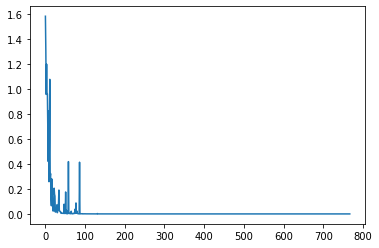

In [10]:
plt.plot(los)

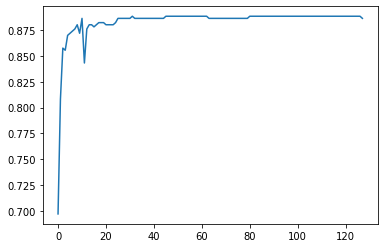

In [11]:
plt.plot(acc)

In [12]:
print('acc: ', max(acc))

acc:  0.8886597938144329
